# Using Segmentation_Models 

We will use [segmentation_models](https://github.com/qubvel/segmentation_models) package to use several pretrained models to do image segmentation

## Reading Dataset

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import random
import imutils
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
DATA_DIR = '..//data'

In [3]:
seed = 5

In [4]:
images = os.listdir(os.path.join(DATA_DIR, 'images', 'bird')) + os.listdir(os.path.join(DATA_DIR, 'images', 'insect'))
masks = os.listdir(os.path.join(DATA_DIR, 'labels', 'bird')) + os.listdir(os.path.join(DATA_DIR, 'labels', 'insect'))
labels = [1]*len(os.listdir(os.path.join(DATA_DIR, 'labels', 'bird'))) + [2]*len(os.listdir(os.path.join(DATA_DIR, 'labels', 'insect')))

In [10]:
indices = np.arange(len(images))

In [5]:
assert len(images) == len(masks)
assert len(masks) == len(labels)

In [6]:
widths = []
heights = []
for i, image in tqdm_notebook(enumerate(images), total = len(images)):
    im = cv2.imread('..//data//images//{}//{}'.format('bird' if labels[i]==1 else 'insect', image))
    
    widths.append(im.shape[0])
    heights.append(im.shape[1])

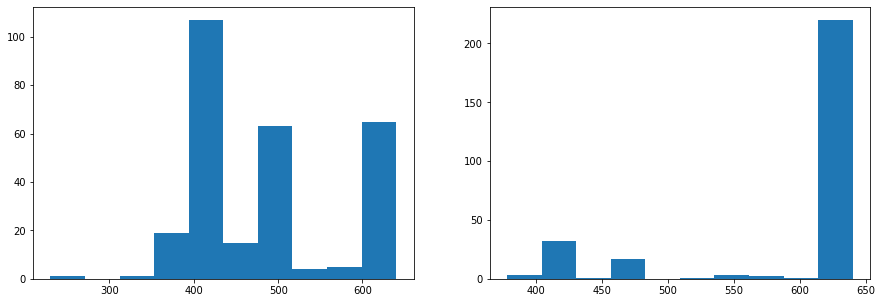

In [7]:
f, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].hist(widths)
ax[1].hist(heights)
plt.show()

## Preprocessing Dataset

In [8]:
def pad_images_to_same_size(images):
    """
    :param images: sequence of images
    :return: list of images padded so that all images have same width and height (max width and height are used)
    """
    width_max = 640
    height_max = 640
    
    for img in images:
        h, w = img.shape[0], img.shape[1]
        width_max = max(width_max, w)
        height_max = max(height_max, h)

    images_padded = []
    for img in images:
        h, w = img.shape[0], img.shape[1]
        diff_vert = height_max - h
        pad_top = diff_vert//2
        pad_bottom = diff_vert - pad_top
        diff_hori = width_max - w
        pad_left = diff_hori//2
        pad_right = diff_hori - pad_left
        img_padded = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
        assert img_padded.shape[:2] == (height_max, width_max)
        images_padded.append(img_padded)

    return images_padded

def readpgm(ID):
        
        with open(ID) as f:

            lines = f.readlines()

        # This ignores commented lines

        for l in list(lines):

            if l[0] == '#':

                lines.remove(l)

        # here,it makes sure it is ASCII format (P2)

        assert lines[0].strip() == 'P2' 

        # Converts data to a list of integers

        data = []

        for line in lines[1:]:

            data.extend([int(c) for c in line.split()])

        return np.array(data[3:]).reshape((data[1],data[0]))*255

In [11]:
for i, idx in tqdm_notebook(enumerate(indices), total = len(indices)):
    im_path = '..//data//images//{}//'.format('bird' if labels[idx]==1 else 'insect')
    mask_path = '..//data//labels//{}//'.format('bird' if labels[idx]==1 else 'insect')
    im = cv2.cvtColor(cv2.imread('{}{}'.format(im_path, images[idx])), cv2.COLOR_BGR2RGB)
    mask = readpgm('{}{}'.format(mask_path, masks[idx]))
    
    im_ = pad_images_to_same_size([im])[0]
    mask_ = pad_images_to_same_size([mask])[0]
    
    im_path = '..//data//images_//{}//'.format('bird' if labels[idx]==1 else 'insect')
    mask_path = '..//data//labels_//{}//'.format('bird' if labels[idx]==1 else 'insect')

    cv2.imwrite('{}//{}'.format(im_path, images[idx]), cv2.cvtColor(im_, cv2.COLOR_RGB2BGR))
    cv2.imwrite('{}//{}'.format(mask_path, '{}.jpg'.format(masks[idx].split('.')[0])), mask_)

## Building the Data Generator

In [7]:
images = os.listdir(os.path.join(DATA_DIR, 'images_', 'bird')) + os.listdir(os.path.join(DATA_DIR, 'images_', 'insect'))
masks = os.listdir(os.path.join(DATA_DIR, 'labels_', 'bird')) + os.listdir(os.path.join(DATA_DIR, 'labels_', 'insect'))
labels = [1]*len(os.listdir(os.path.join(DATA_DIR, 'labels_', 'bird'))) + [2]*len(os.listdir(os.path.join(DATA_DIR, 'labels_', 'insect')))

In [8]:
assert len(images) == len(masks)
assert len(masks) == len(labels)

In [9]:
indices = np.arange(len(images))

In [10]:
widths = []
heights = []
for i, image in tqdm_notebook(enumerate(images), total = len(images)):
    im = cv2.imread('..//data//images_//{}//{}'.format('bird' if labels[i]==1 else 'insect', image))
    
    widths.append(im.shape[0])
    heights.append(im.shape[1])

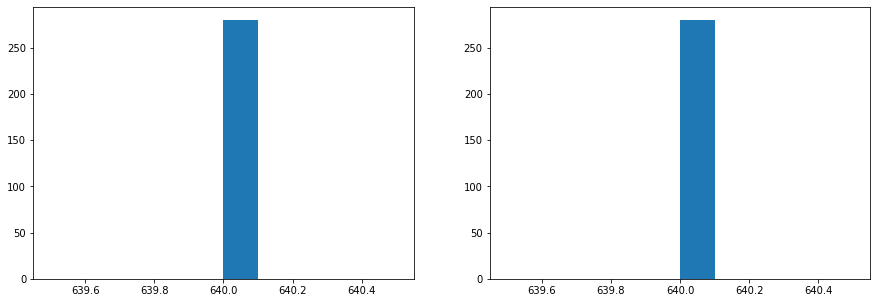

In [11]:
f, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].hist(widths)
ax[1].hist(heights)
plt.show()

In [12]:
x_train, x_, y_train, y_ = train_test_split(indices, labels, test_size = 0.5, random_state = seed, stratify = labels)
x_val, x_test, y_val, y_test = train_test_split(x_, y_, test_size = 0.6, random_state = seed, stratify = y_)

In [13]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_val))
print(Counter(y_test))

Counter({1: 75, 2: 65})
Counter({1: 30, 2: 26})
Counter({1: 45, 2: 39})


In [14]:
print('Train {}, Val {}, Test {}'.format(len(x_train), len(x_val), len(x_test)))

Train 140, Val 56, Test 84


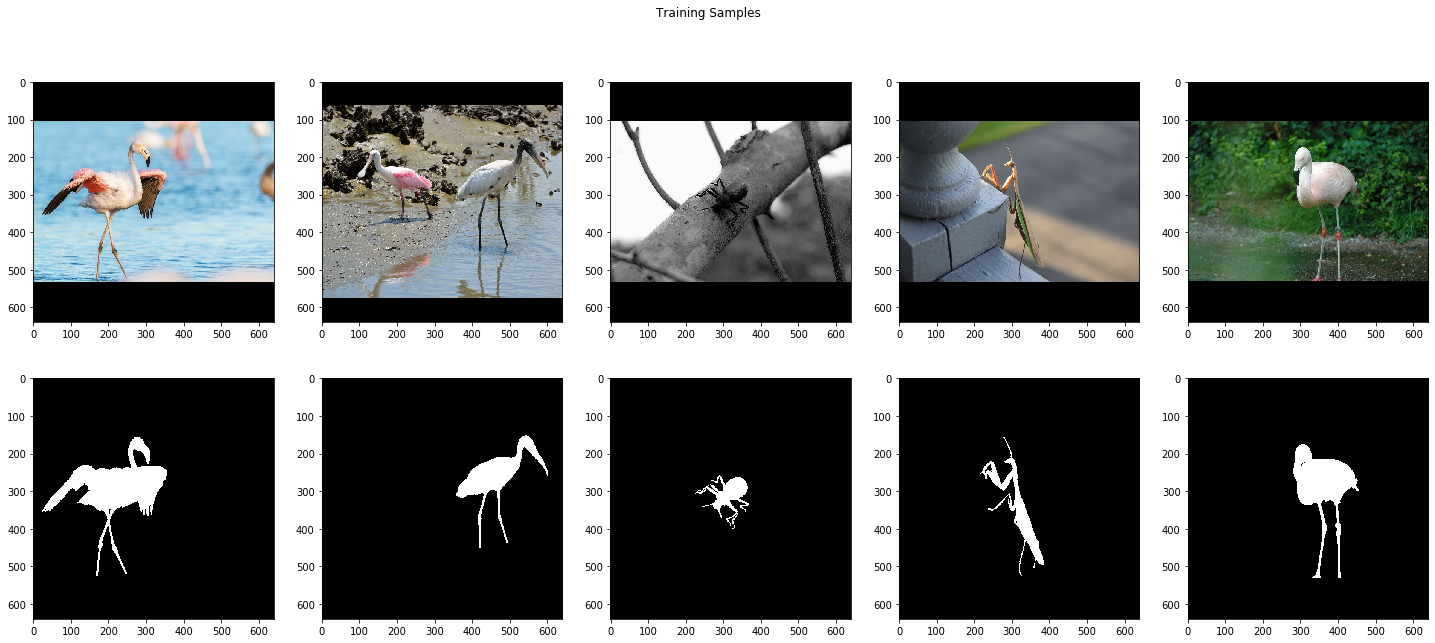

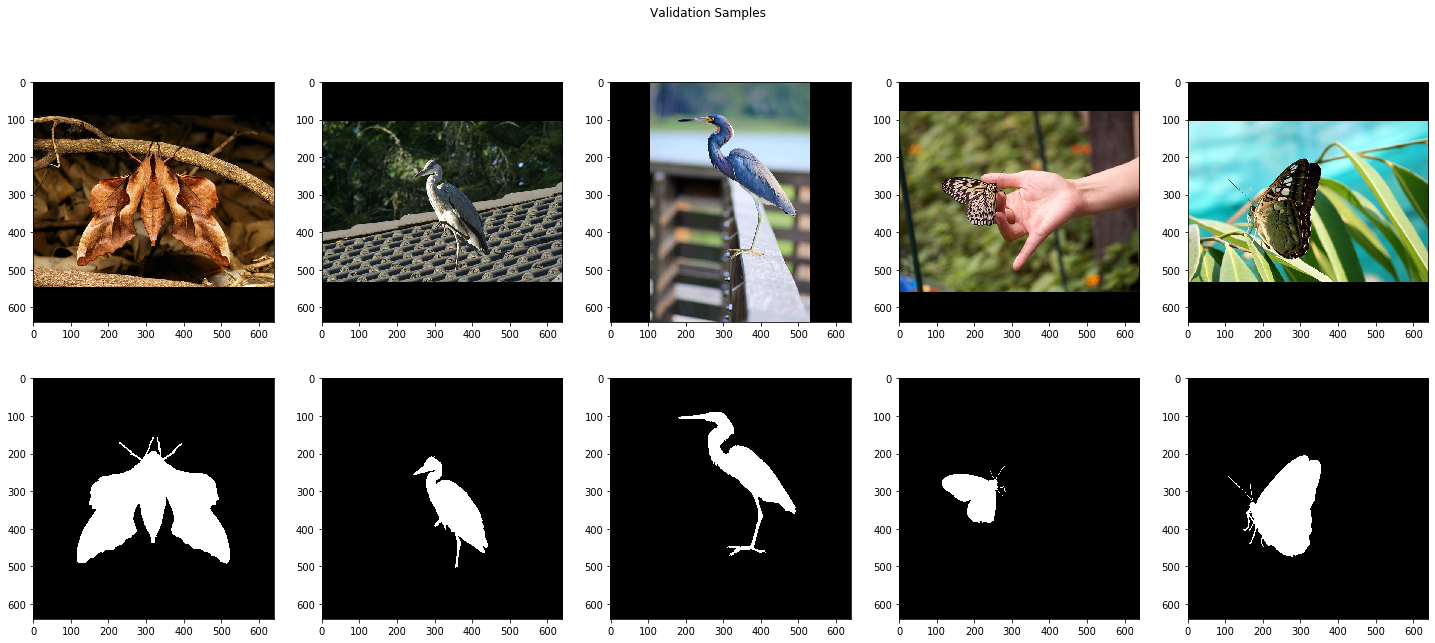

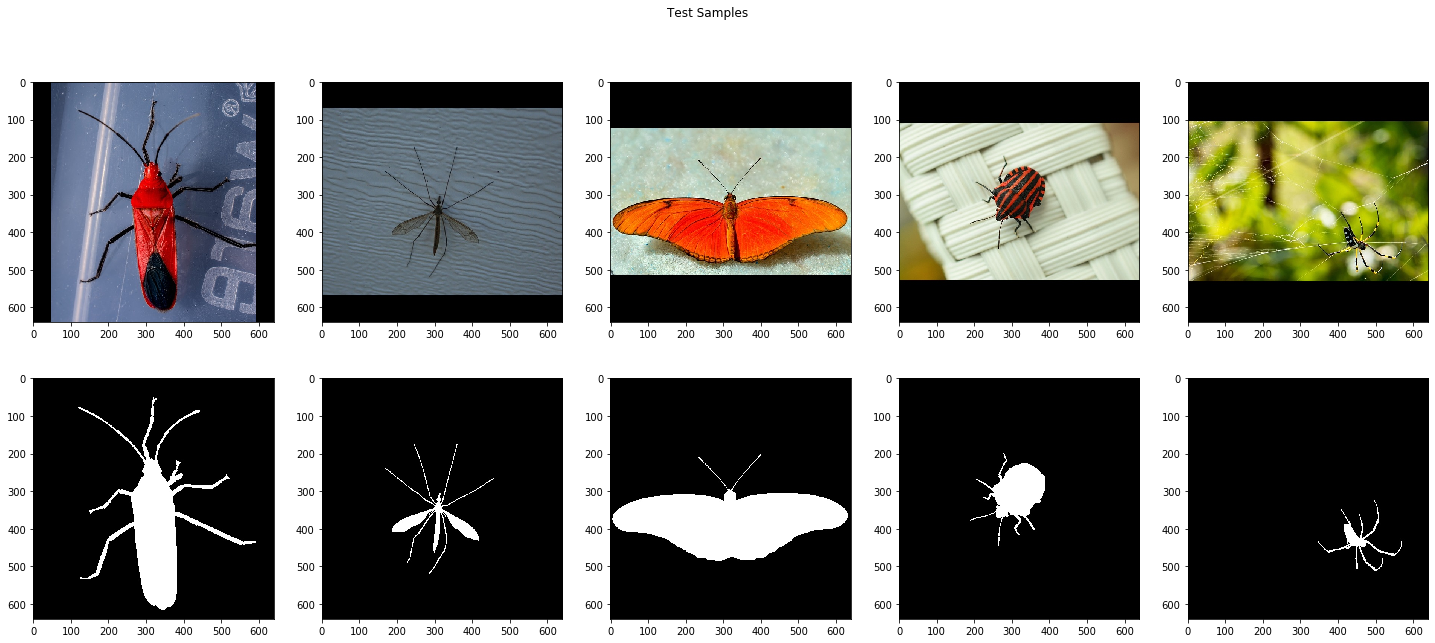

In [15]:
# helper function for data visualization
def visualize(images, masks, title):
    
    f, ax = plt.subplots(2, len(images), figsize = (25, 10))
    for i, (im, ms) in enumerate(zip(images, masks)):
        
        ax[0][i].imshow(im)
        ax[1][i].imshow(ms, cmap = 'gray')
    plt.suptitle(title)
    plt.show()
        
sample = random.choices(np.arange(len(x_train)), k = 5)
imgs = [cv2.cvtColor(cv2.imread('..//data//images_//{}//{}'.format('bird' if y_train[i]==1 else 'insect', images[x_train[i]])), cv2.COLOR_BGR2RGB) for i in sample]
msks = [cv2.imread('..//data//labels_//{}//{}'.format('bird' if y_train[i]==1 else 'insect', masks[x_train[i]])) for i in sample]
visualize(imgs, msks, title = 'Training Samples')

sample = random.choices(np.arange(len(x_val)), k = 5)
imgs = [cv2.cvtColor(cv2.imread('..//data//images_//{}//{}'.format('bird' if y_val[i]==1 else 'insect', images[x_val[i]])), cv2.COLOR_BGR2RGB) for i in sample]
msks = [cv2.imread('..//data//labels_//{}//{}'.format('bird' if y_val[i]==1 else 'insect', masks[x_val[i]])) for i in sample]
visualize(imgs, msks, title = 'Validation Samples')

sample = random.choices(np.arange(len(x_test)), k = 5)
imgs = [cv2.cvtColor(cv2.imread('..//data//images_//{}//{}'.format('bird' if y_test[i]==1 else 'insect', images[x_test[i]])), cv2.COLOR_BGR2RGB) for i in sample]
msks = [cv2.imread('..//data//labels_//{}//{}'.format('bird' if y_test[i]==1 else 'insect', masks[x_test[i]])) for i in sample]
visualize(imgs, msks, title = 'Test Samples')

In [16]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, images, masks, labels, label_map = {1: 'bird', 2: 'insect'}, 
                 train_path = '..//data', mode = 'fit', batch_size=32, 
                 dim=(640,640), augment = False, reshape = None, 
                 n_channels=3, n_classes=3, random_state = 5, shuffle=True):
        'Initialization'
        
        self.list_IDs = list_IDs
        self.images = images
        self.masks = masks
        self.labels = labels
        self.label_map = label_map
        self.train_path = train_path
        self.mode = mode
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.dim = dim
        self.augment = augment
        self.reshape = reshape
        self.n_channels = n_channels
        self.n_classes = n_classes        
        self.random_state = random_state
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Find list of IDs
        list_IDs_ = self.list_IDs[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        if(self.mode == 'fit'):
            images, maps = self.__data_generation(list_IDs_)
            
            return images, maps
        else:
            images = self.__data_generation(list_IDs_)
            
            return images
    
    def __data_generation(self, indices):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        if(self.reshape is None):
            image_batch = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            image_batch = np.empty((self.batch_size, *self.reshape, self.n_channels))
            
        # Generate data
        for i, ID in enumerate(indices):
            # Store sample
            image_batch[i,] = self.load_image(ID)
        
        if(self.mode == 'fit'):
            if(self.reshape is None):
                mask_batch = np.empty((self.batch_size, *self.dim, self.n_classes))
            else:
                mask_batch = np.empty((self.batch_size, *self.reshape, self.n_classes))

            # Generate data
            for i, ID in enumerate(indices):
                # Store class
                mask_batch[i, ] = self.make_gt(ID)
                
            if self.augment:
                image_batch, mask_batch = self._augment_batch(image_batch, mask_batch)
                       
            return image_batch, mask_batch
        else:
            return image_batch
        
    def load_image(self, ID):
        
        path = '{}//images_//{}//{}'.format(self.train_path, self.label_map[self.labels[ID]], self.images[ID])
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.
        
        if(self.reshape is not None):
            img = imutils.resize(img, height = self.reshape[0])

        return img
    
    def make_gt(self, ID):
        
        mask = cv2.imread('{}//labels_//{}//{}.jpg'.format(self.train_path, self.label_map[self.labels[ID]], self.masks[ID].split('.')[0]))
        mask = mask.astype(np.float32)/255.
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
                
        gt = np.zeros((*self.dim, self.n_classes))
        
        if self.labels[ID]  == 1:
            gt[:, :, 1] = mask
            gt[:, :, 0] = 1 - gt[:, :, 1]
        elif self.labels[ID] == 2:
            gt[:, :, 2] = mask
            gt[:, :, 0] = 1 - gt[:, :, 2]
            
        if(self.reshape is not None):
            gt = imutils.resize(gt, height = self.reshape[0])
            
        return gt

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
            
    def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

    # define heavy augmentations
    def get_training_augmentation():
        train_transform = [

            A.HorizontalFlip(p=0.5),

            A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

            A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
            A.RandomCrop(height=320, width=320, always_apply=True),

            A.IAAAdditiveGaussianNoise(p=0.2),
            A.IAAPerspective(p=0.5),

            A.OneOf(
                [
                    A.CLAHE(p=1),
                    A.RandomBrightness(p=1),
                    A.RandomGamma(p=1),
                ],
                p=0.9,
            ),

            A.OneOf(
                [
                    A.IAASharpen(p=1),
                    A.Blur(blur_limit=3, p=1),
                    A.MotionBlur(blur_limit=3, p=1),
                ],
                p=0.9,
            ),

            A.OneOf(
                [
                    A.RandomContrast(p=1),
                    A.HueSaturationValue(p=1),
                ],
                p=0.9,
            ),
            A.Lambda(mask=round_clip_0_1)
        ]
        return A.Compose(train_transform)


    def get_validation_augmentation():
        """Add paddings to make image shape divisible by 32"""
        test_transform = [
            A.PadIfNeeded(384, 480)
        ]
        return A.Compose(test_transform)

    def get_preprocessing(preprocessing_fn):
        """Construct preprocessing transform

        Args:
            preprocessing_fn (callbale): data normalization function 
                (can be specific for each pretrained neural network)
        Return:
            transform: albumentations.Compose

        """

        _transform = [
            A.Lambda(image=preprocessing_fn),
        ]
        return A.Compose(_transform)

In [17]:
trainGen = DataGenerator(x_train, images, masks, labels, batch_size=5, reshape = (320, 320))

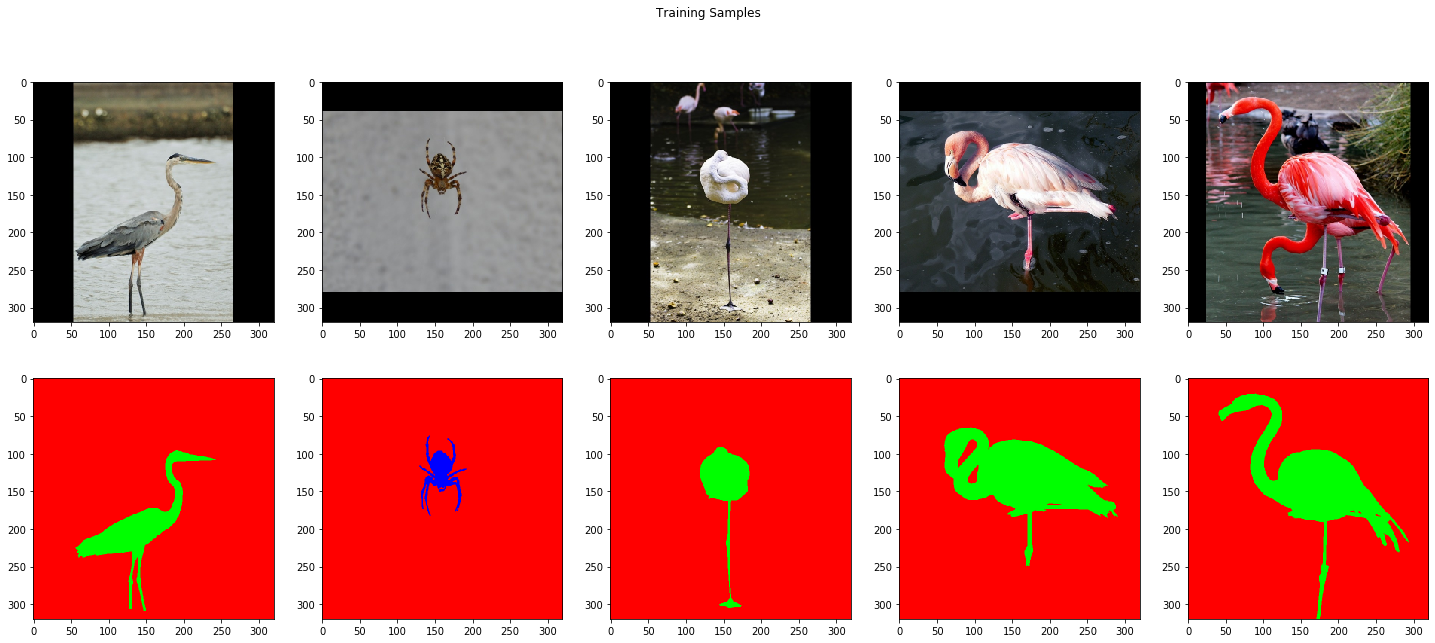

In [18]:
visualize(trainGen[0][0], trainGen[0][1], title = 'Training Samples')

## Building Segmentation Model

In [19]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [20]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 1
CLASSES = ['bird', 'insect']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [21]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

W0510 21:29:16.593219  1064 deprecation_wrapper.py:119] From c:\users\worka\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0510 21:29:16.608149  1064 deprecation_wrapper.py:119] From c:\users\worka\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0510 21:29:16.611142  1064 deprecation_wrapper.py:119] From c:\users\worka\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0510 21:29:16.631116  1064 deprecation_wrapper.py:119] From c:\users\worka\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_sessio

In [22]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

W0510 21:29:29.766554  1064 deprecation_wrapper.py:119] From c:\users\worka\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [23]:
trainGen = DataGenerator(x_train, images, masks, labels, batch_size=BATCH_SIZE, reshape = (320, 320))
valGen = DataGenerator(x_val, images, masks, labels, batch_size=BATCH_SIZE, reshape = (320, 320))


# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [28]:
# train model
history = model.fit_generator(
    trainGen, 
    steps_per_epoch=100, 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valGen, 
    validation_steps=100,
    verbose = 2
)

Epoch 1/40
 - 38s - loss: 0.5415 - iou_score: 0.4469 - f1-score: 0.4767 - val_loss: 0.5821 - val_iou_score: 0.4196 - val_f1-score: 0.4534
Epoch 2/40
 - 38s - loss: 0.5141 - iou_score: 0.4530 - f1-score: 0.4828 - val_loss: 0.5573 - val_iou_score: 0.4277 - val_f1-score: 0.4713
Epoch 3/40
 - 38s - loss: 0.4617 - iou_score: 0.4738 - f1-score: 0.5043 - val_loss: 0.5251 - val_iou_score: 0.4489 - val_f1-score: 0.4950
Epoch 4/40
 - 38s - loss: 0.4242 - iou_score: 0.5011 - f1-score: 0.5373 - val_loss: 0.5078 - val_iou_score: 0.4696 - val_f1-score: 0.5186
Epoch 5/40
 - 38s - loss: 0.4449 - iou_score: 0.5134 - f1-score: 0.5546 - val_loss: 0.5523 - val_iou_score: 0.4920 - val_f1-score: 0.5397
Epoch 6/40
 - 38s - loss: 0.3594 - iou_score: 0.5538 - f1-score: 0.5903 - val_loss: 0.4742 - val_iou_score: 0.5090 - val_f1-score: 0.5571
Epoch 7/40
 - 38s - loss: 0.3711 - iou_score: 0.5745 - f1-score: 0.6097 - val_loss: 0.4874 - val_iou_score: 0.4704 - val_f1-score: 0.4970
Epoch 8/40
 - 38s - loss: 0.3303 -

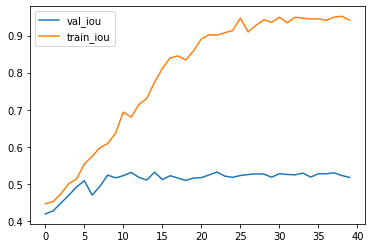

In [34]:
plt.plot(history.history['val_iou_score'], label = 'val_iou')
plt.plot(history.history['iou_score'], label = 'train_iou')
plt.legend()
plt.show()

In [54]:
testGen = DataGenerator(x_test, images, masks, labels, batch_size=5, reshape = (320, 320))

In [57]:
pred = model.predict_generator(testGen)

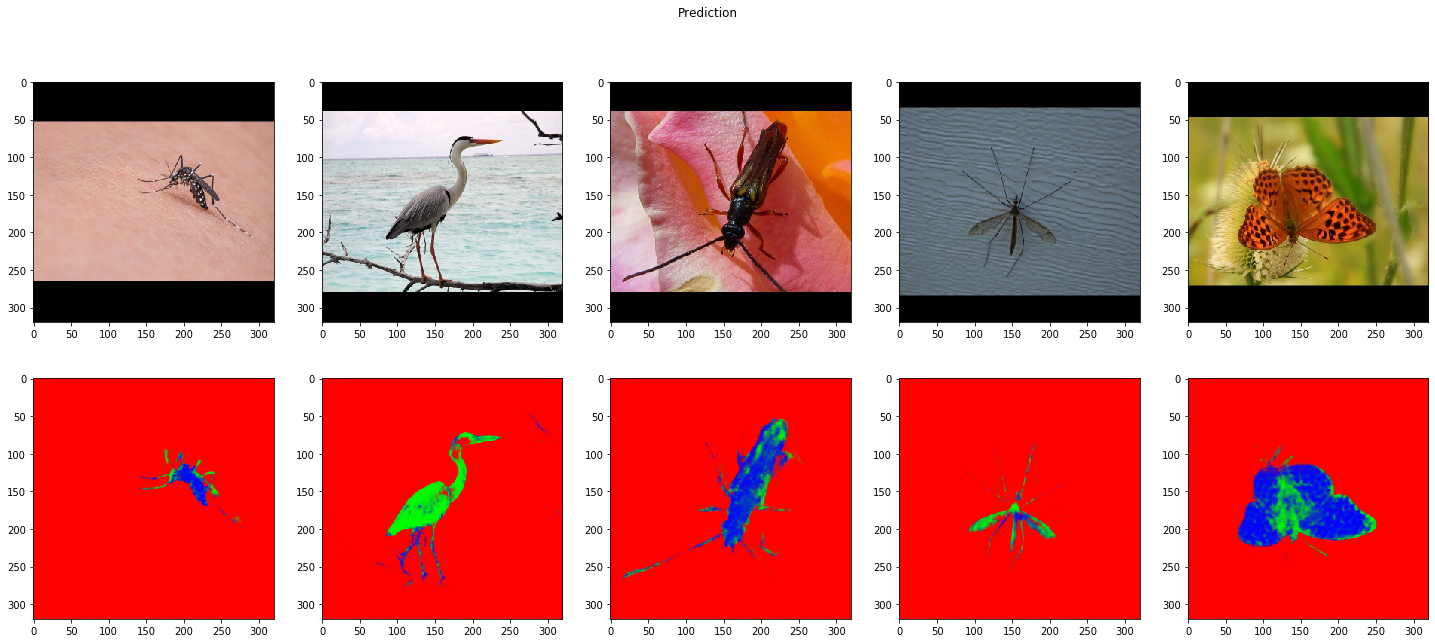

In [71]:
visualize(testGen[3][0][0:5], pred[15:20], title = 'Prediction')

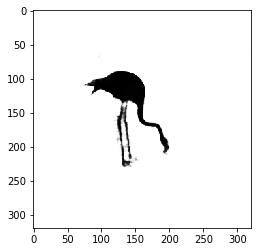

In [70]:
plt.imshow(pred[0][:, :, 0], cmap = 'gray')

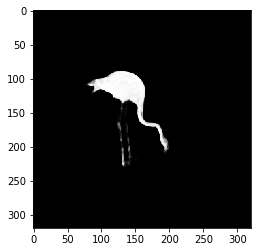

In [61]:
plt.imshow(pred[0][:, :, 1], cmap = 'gray')

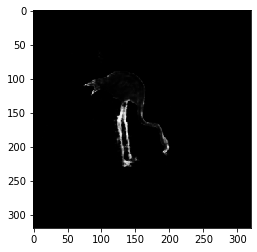

In [62]:
plt.imshow(pred[0][:, :, 2], cmap = 'gray')